# Import libraries, check version

In [ ]:
import torch
import torchvision
import matplotlib
import numpy
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import platform
import os
from platform import python_version
print('os name:',platform.system(),platform.release())
print('python version :',python_version())
print('torch version :',torch.__version__)
print('torchvision version :',torchvision.__version__)
print('matplotlib version :',matplotlib.__version__)
print('numpy version :',numpy.__version__)


os name: Linux 5.4.109+
python version : 3.7.10
torch version : 1.8.1+cu101
torchvision version : 0.9.1+cu101
matplotlib version : 3.2.2
numpy version : 1.19.5


# Train_loader, Test_loader

In [ ]:
def get_loader(batch_size):
  train_data=torchvision.datasets.FashionMNIST(root='Fashion_data/',
                                              train=True,
                                              transform=torchvision.transforms.ToTensor(),
                                              download=True)
  
  train_data_loader=torch.utils.data.DataLoader(dataset=train_data,
                                        batch_size=batch_size,
                                        drop_last=True,
                                        shuffle=True
                                        )
  test_data=torchvision.datasets.FashionMNIST(root='Fashion_data/',
                                             train=False,
                                             transform=torchvision.transforms.ToTensor(),
                                             download=True)
  test_data_loader=torch.utils.data.DataLoader(dataset=test_data,
                                        batch_size=len(test_data),
                                        )
  return train_data_loader,test_data_loader

# FC_Network structure

In [ ]:
class FC_Network(nn.Module):
  def __init__(self):
    super(FC_Network,self).__init__()
    self.fc1=nn.Linear(28*28,512,bias=True)
    self.fc2=nn.Linear(512,10,bias=True)
    self.relu=nn.ReLU()
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)

  def forward(self,x):
    x=self.fc1(x.reshape(x.shape[0],-1))
    x=self.relu(x)
    x=self.fc2(x)
    return x

# LENET_5 structure

In [ ]:
class Lenet_5(nn.Module):
  def __init__(self,softmax_exist=False,
               activation_function='tanh',
               first_channel=6,
               second_channel=16,
               third_channel=120,
               use_batchnorm=False,
               pooling_layer='avg',
               use_dropout=False):
    super(Lenet_5,self).__init__()
    self.con1=nn.Conv2d(in_channels=1,out_channels=first_channel,kernel_size=5,stride=1,padding=2)
    self.con2=nn.Conv2d(in_channels=first_channel,out_channels=second_channel,kernel_size=5,stride=1)
    self.con3=nn.Conv2d(in_channels=second_channel,out_channels=third_channel,kernel_size=5,stride=1)

    self.use_batchnormflag=use_batchnorm
    self.batchnorm1=nn.BatchNorm2d(first_channel)
    self.batchnorm2=nn.BatchNorm2d(second_channel)
    self.batchnorm3=nn.BatchNorm2d(third_channel)

    if activation_function=='tanh':
      self.activation_function=nn.Tanh()
    elif activation_function=='relu':
      self.activation_function=nn.ReLU()
    elif activation_function=='leaky_relu':
      self.activation_function=nn.LeakyReLU()

    if pooling_layer=='avg':
      self.pooling_layer=nn.AvgPool2d(2)
    elif pooling_layer=='max':
      self.pooling_layer=nn.MaxPool2d(2)

    self.fc1=nn.Linear(third_channel,84)
    self.fc2=nn.Linear(84,10)

    self.sflag=softmax_exist
    self.softmax=nn.Softmax(1)

    self.dflag=use_dropout
    self.dropout=nn.Dropout(0.3)

    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)

  def forward(self,x):
    x=self.con1(x)
    if self.use_batchnormflag==True:
      x=self.batchnorm1(x)
    x=self.activation_function(x)
    x=self.pooling_layer(x)

    x=self.con2(x)
    if self.use_batchnormflag==True:
      x=self.batchnorm2(x)
    x=self.activation_function(x)
    x=self.pooling_layer(x)

    x=self.con3(x)
    if self.use_batchnormflag==True:
      x=self.batchnorm3(x)
    x=self.activation_function(x)

    x=x.reshape(x.shape[0],-1)

    x=self.fc1(x)
    if self.dflag:
      x=self.dropout(x)
    x=self.activation_function(x)
    x=self.fc2(x)
    if self.sflag:
      x=self.softmax(x)
    return x

# Training FC_Network

In [ ]:
def train_FC(training_epoch,batch_size,learning_rate):
  device='cpu'
  if torch.cuda.is_available():
    device='cuda'
  print('using device :',device)

  train_data_loader,test_data_loader=get_loader(batch_size=batch_size)

  model=FC_Network().to(device)
  criterion=nn.CrossEntropyLoss().to(device)
  optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
  print('hyper parameter')
  print('training epoch :',training_epoch)
  print('batch_size :',batch_size)
  print('learning rate :',learning_rate)
  
  epoch_num=0
  loss_per_epoch=[]
  batch_len=len(train_data_loader)
  for epoch in range(training_epoch):
    epoch_num+=1
    training_loss=0
    for imgs,labels in train_data_loader:
      imgs=imgs.to(device)
      labels=labels.to(device)
      predictions=model(imgs)
      loss_function=criterion(predictions,labels)
      optimizer.zero_grad()
      loss_function.backward()
      optimizer.step()
      training_loss+=loss_function.item()/batch_len
    print('epoch :',epoch_num,'\ttraining_loss :',training_loss)
    loss_per_epoch.append(training_loss)

  plt.plot([*range(1,training_epoch+1)],loss_per_epoch)
  plt.xticks([*range(1,training_epoch+1)])
  plt.scatter([*range(1,training_epoch+1)],loss_per_epoch)
  plt.show()

  with torch.no_grad():
    correct=0
    incorrect=0
    for imgs,labels in test_data_loader:
      imgs=imgs.to(device)
      labels=labels.to(device)
      test_prediction=model(imgs)
      correct_prediction=torch.argmax(test_prediction,1)==labels
      correct+=correct_prediction.sum().item()
      incorrect+=correct_prediction.shape[0]-correct_prediction.sum().item()
  print('Accuracy :'+str(correct/(correct+incorrect)))

using device : cuda



Extracting Fashion_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to Fashion_data/FashionMNIST/raw




Extracting Fashion_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to Fashion_data/FashionMNIST/raw




Extracting Fashion_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to Fashion_data/FashionMNIST/raw




Extracting Fashion_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to Fashion_data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


hyper parameter
training epoch : 20
batch_size : 100
learning rate : 0.001
epoch : 1 	training_loss : 0.495813971608877
epoch : 2 	training_loss : 0.3677181304494539
epoch : 3 	training_loss : 0.32561930939555167
epoch : 4 	training_loss : 0.30498001990218987
epoch : 5 	training_loss : 0.283045635695259
epoch : 6 	training_loss : 0.270513646317025
epoch : 7 	training_loss : 0.2579276085769136
epoch : 8 	training_loss : 0.24486684974282982
epoch : 9 	training_loss : 0.23612460444370886
epoch : 10 	training_loss : 0.22543179320792367
epoch : 11 	training_loss : 0.21766769719620535
epoch : 12 	training_loss : 0.2102476958061258
epoch : 13 	training_loss : 0.20200535130997513
epoch : 14 	training_loss : 0.1944414099616308
epoch : 15 	training_loss : 0.18416485485931222
epoch : 16 	training_loss : 0.18076260276138817
epoch : 17 	training_loss : 0.17380437310164157
epoch : 18 	training_loss : 0.16885349992041798
epoch : 19 	training_loss : 0.1663701677136122
epoch : 20 	training_loss : 0.157

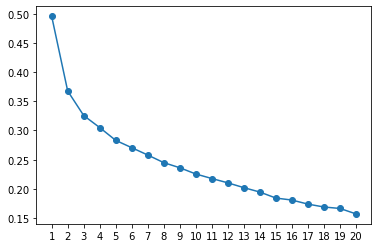

Accuracy :0.894


In [ ]:
train_FC(training_epoch=20, batch_size=100, learning_rate=0.001)

# Training Lenet_5

In [ ]:
def train_Lenet(training_epoch=20,
                batch_size=100,
                learning_rate=0.001,
                scheduler_name=None,
                scheduler_step_size=None,
                scheduler_gamma=None,
                optimizer_name='Adam',
                loss_function_name='CrossEntropyLoss',
                activation_function='tanh',
                first_channel=6,
                second_channel=16,
                third_channel=120,
                use_batchnorm=False,
                pooling_layer='avg',
                use_dropout=False):
  
  #check if gpu is available
  device='cpu'
  if torch.cuda.is_available():
    device='cuda'
  print('using device :',device)

  #get train data loader and test data loader
  train_data_loader,test_data_loader=get_loader(batch_size=batch_size)

  #depending on the loss function, define criterion and choose whether softmax layer has to exist in the model
  if loss_function_name=='CrossEntropyLoss':
    criterion=nn.CrossEntropyLoss().to(device)
    softmax_exist=False
  elif loss_function_name=='MultiMarginLoss':
    criterion=nn.MultiMarginLoss().to(device)
    softmax_exist=False
  elif loss_function_name=='MSELoss':
    criterion=nn.MSELoss().to(device)
    softmax_exist=True
  
  #define model
  model=Lenet_5(softmax_exist=softmax_exist,
                activation_function=activation_function,
                first_channel=first_channel,
                second_channel=second_channel,
                third_channel=third_channel,
                use_batchnorm=use_batchnorm,
                pooling_layer=pooling_layer,
                use_dropout=use_dropout).to(device)

  #depending on the optimizer name, define optimizer
  if optimizer_name=='Adam':
    optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
  elif optimizer_name=='SGD':
    optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)
  elif optimizer_name=='RMSprop':
    optimizer=torch.optim.RMSprop(model.parameters(),lr=learning_rate)

  #depending on the scheduler name, if exist, set scheduler
  if scheduler_name=='StepLR':
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer=optimizer,
                                          step_size=scheduler_step_size,
                                          gamma=scheduler_gamma
                                          )

  #print the setting
  print('training epoch :',training_epoch)
  print('batch size :',batch_size)
  print('learning rate :',learning_rate)
  print('scheduler name :',scheduler_name)
  print('scheduler step size :',scheduler_step_size)
  print('scheduler gamma :',scheduler_gamma)
  print('optimizer name: ',optimizer_name)
  print('loss function :',loss_function_name)
  print('activation function :', activation_function)
  print('convolutional channels :',first_channel,second_channel,third_channel)
  print('using batch normalization? :',use_batchnorm)
  print('pooling layer :',pooling_layer)
  print('using dropout layer :',use_dropout)
  
  epoch_num=0
  loss_per_epoch=[]
  batch_len=len(train_data_loader)
  model.train()
  for epoch in range(training_epoch):
    epoch_num+=1
    training_loss=0
    for imgs,labels in train_data_loader:
      imgs=imgs.to(device)

      #depending on the loss function, change which the label format to use(index/one hot encoding)
      if loss_function_name=='CrossEntropyLoss':
        labels=labels.to(device)
      elif loss_function_name=='MultiMarginLoss':
        labels=labels.to(device)
      elif loss_function_name=='MSELoss':
        labels=torch.zeros(labels.shape[0],10).scatter_(1,labels.unsqueeze(1),1.).to(device)

      predictions=model(imgs)
      loss_function=criterion(predictions,labels)
      optimizer.zero_grad()
      loss_function.backward()
      optimizer.step()

      #if there is a scheduler, adjust learning rate using scheduler
      if scheduler_name!=None:
        scheduler.step()

      training_loss+=loss_function.item()/batch_len
    print('epoch :',epoch_num,'\ttraining_loss :',training_loss)
    loss_per_epoch.append(training_loss)

  plt.plot([*range(1,training_epoch+1)],loss_per_epoch)
  plt.xticks([*range(1,training_epoch+1)])
  plt.scatter([*range(1,training_epoch+1)],loss_per_epoch)
  plt.show()
  
  model.eval()
  with torch.no_grad():
    correct=0
    incorrect=0
    for imgs,labels in test_data_loader:
      imgs=imgs.to(device)
      labels=labels.to(device)
      test_prediction=model(imgs)
      correct_prediction=torch.argmax(test_prediction,1)==labels
      correct+=correct_prediction.sum().item()
      incorrect+=correct_prediction.shape[0]-correct_prediction.sum().item()
  print('Accuracy :'+str(correct/(correct+incorrect)))

# Base

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.5915302080909413
epoch : 2 	training_loss : 0.4162714382757741
epoch : 3 	training_loss : 0.3683476631343365
epoch : 4 	training_loss : 0.3367751090725265
epoch : 5 	training_loss : 0.3156569691002368
epoch : 6 	training_loss : 0.29816059184571114
epoch : 7 	training_loss : 0.2823769128074243
epoch : 8 	training_loss : 0.2695798568055033
epoch : 9 	training_loss : 0.2575767493868867
epoch : 10 	training_loss : 0.24603730042775462
epoch : 11 	training_loss : 0.23712480699022592
epoch : 12 	training_loss : 0.2277970467632015
epoch : 13 	training_loss : 0.21742597583681347
epoch : 14 	training_loss : 0.20787252048651

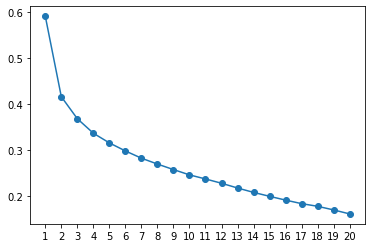

Accuracy :0.8924


In [ ]:
train_Lenet()

# optimizer parameter - scheduler

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.5978506713608905
epoch : 2 	training_loss : 0.415192663744092
epoch : 3 	training_loss : 0.36447608575224877
epoch : 4 	training_loss : 0.3367993022253117
epoch : 5 	training_loss : 0.3155414356788002
epoch : 6 	training_loss : 0.2971906841546299
epoch : 7 	training_loss : 0.28450000637521344
epoch : 8 	training_loss : 0.26934149313718064
epoch : 9 	training_loss : 0.25755699691673123
epoch : 10 	training_loss : 0.24804836013664816
epoch : 11 	training_loss : 0.23585064548999077
epoch : 12 	training_loss : 0.227778815254569
epoch : 13 	training_loss : 0.21847712772587935
epoch : 14 	training_loss : 0.2108854663123

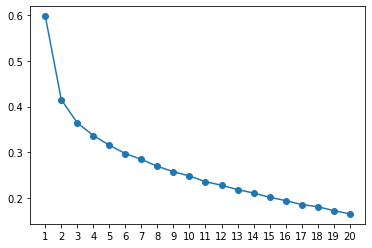

Accuracy :0.892


In [ ]:
train_Lenet(scheduler_name=None)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : StepLR
scheduler step size : 100
scheduler gamma : 0.9
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.6180613595743976
epoch : 2 	training_loss : 0.43632056931654606
epoch : 3 	training_loss : 0.395517683327198
epoch : 4 	training_loss : 0.37678616382181657
epoch : 5 	training_loss : 0.36749397061765215
epoch : 6 	training_loss : 0.3622086900720991
epoch : 7 	training_loss : 0.3597026750942071
epoch : 8 	training_loss : 0.35820335018138116
epoch : 9 	training_loss : 0.3573904731372995
epoch : 10 	training_loss : 0.3570248475422462
epoch : 11 	training_loss : 0.35677012691895205
epoch : 12 	training_loss : 0.3566447369505964
epoch : 13 	training_loss : 0.3565733834107713
epoch : 14 	training_loss : 0.35653590070704

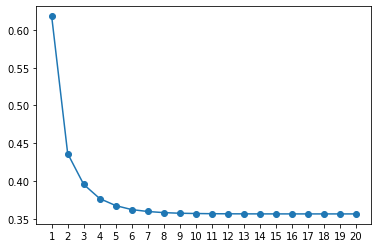

Accuracy :0.8607


In [ ]:
train_Lenet(learning_rate=0.001, scheduler_name='StepLR', scheduler_step_size=100, scheduler_gamma=0.9)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : StepLR
scheduler step size : 200
scheduler gamma : 0.9
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.617796214818955
epoch : 2 	training_loss : 0.4191420417030655
epoch : 3 	training_loss : 0.3716379365324978
epoch : 4 	training_loss : 0.3463144936164223
epoch : 5 	training_loss : 0.33052522264421
epoch : 6 	training_loss : 0.31892224363982674
epoch : 7 	training_loss : 0.3115380549679201
epoch : 8 	training_loss : 0.3057482208063206
epoch : 9 	training_loss : 0.3014621153722209
epoch : 10 	training_loss : 0.2984754421561953
epoch : 11 	training_loss : 0.29625765565782813
epoch : 12 	training_loss : 0.29453512765467166
epoch : 13 	training_loss : 0.29343517649918804
epoch : 14 	training_loss : 0.2924738258868455


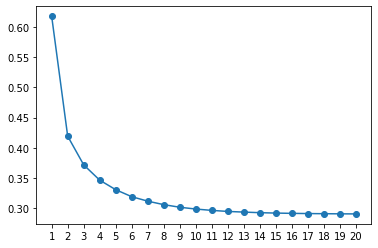

Accuracy :0.8795


In [ ]:
train_Lenet(learning_rate=0.001, scheduler_name='StepLR', scheduler_step_size=200, scheduler_gamma=0.9)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : StepLR
scheduler step size : 400
scheduler gamma : 0.9
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.6009074200441435
epoch : 2 	training_loss : 0.4115277956922849
epoch : 3 	training_loss : 0.3620907775561012
epoch : 4 	training_loss : 0.33570592286686113
epoch : 5 	training_loss : 0.31518347191313933
epoch : 6 	training_loss : 0.30184568387766675
epoch : 7 	training_loss : 0.28870746694505167
epoch : 8 	training_loss : 0.279492983594537
epoch : 9 	training_loss : 0.2703416785846151
epoch : 10 	training_loss : 0.26413932943095775
epoch : 11 	training_loss : 0.25736740607768294
epoch : 12 	training_loss : 0.25297449606160316
epoch : 13 	training_loss : 0.24888778229554473
epoch : 14 	training_loss : 0.24517679636

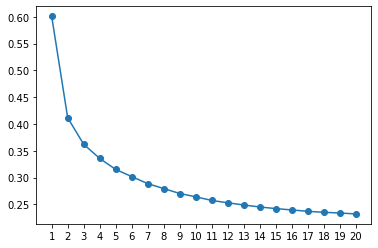

Accuracy :0.8926


In [ ]:
train_Lenet(learning_rate=0.001, scheduler_name='StepLR', scheduler_step_size=400, scheduler_gamma=0.9)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : StepLR
scheduler step size : 800
scheduler gamma : 0.9
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.6019727107385795
epoch : 2 	training_loss : 0.4061948098242281
epoch : 3 	training_loss : 0.3617515151699383
epoch : 4 	training_loss : 0.33379805867870666
epoch : 5 	training_loss : 0.3125373685359958
epoch : 6 	training_loss : 0.29510994801918655
epoch : 7 	training_loss : 0.28240511449674766
epoch : 8 	training_loss : 0.2698678268864747
epoch : 9 	training_loss : 0.25799679880340876
epoch : 10 	training_loss : 0.24985956771920131
epoch : 11 	training_loss : 0.2409666040663917
epoch : 12 	training_loss : 0.232711381527285
epoch : 13 	training_loss : 0.22453996811062096
epoch : 14 	training_loss : 0.2190323355545

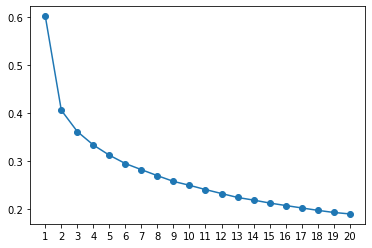

Accuracy :0.8946


In [ ]:
train_Lenet(learning_rate=0.001, scheduler_name='StepLR', scheduler_step_size=800, scheduler_gamma=0.9)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : StepLR
scheduler step size : 1600
scheduler gamma : 0.9
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.6033764415979387
epoch : 2 	training_loss : 0.41978302687406566
epoch : 3 	training_loss : 0.36431549847126016
epoch : 4 	training_loss : 0.33376376971602434
epoch : 5 	training_loss : 0.31279656380414955
epoch : 6 	training_loss : 0.2956114412347477
epoch : 7 	training_loss : 0.2810743123417097
epoch : 8 	training_loss : 0.26826874271035206
epoch : 9 	training_loss : 0.25647145781666053
epoch : 10 	training_loss : 0.24589060942331936
epoch : 11 	training_loss : 0.23660376476744807
epoch : 12 	training_loss : 0.22760236504177248
epoch : 13 	training_loss : 0.22081578056017537
epoch : 14 	training_loss : 0.2116886

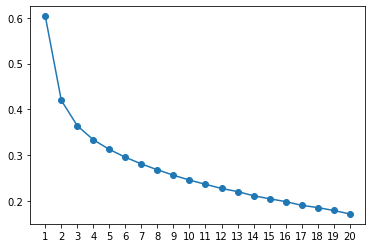

Accuracy :0.8955


In [ ]:
train_Lenet(learning_rate=0.001, scheduler_name='StepLR', scheduler_step_size=1600, scheduler_gamma=0.9)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : StepLR
scheduler step size : 3200
scheduler gamma : 0.9
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.5840853226681562
epoch : 2 	training_loss : 0.40582744434475904
epoch : 3 	training_loss : 0.35916734586159355
epoch : 4 	training_loss : 0.33010780458648975
epoch : 5 	training_loss : 0.30905974050362917
epoch : 6 	training_loss : 0.2907467299327256
epoch : 7 	training_loss : 0.2757790904492141
epoch : 8 	training_loss : 0.26213314200441057
epoch : 9 	training_loss : 0.2524222317834697
epoch : 10 	training_loss : 0.24125636408726361
epoch : 11 	training_loss : 0.23075525065263092
epoch : 12 	training_loss : 0.21877840841809917
epoch : 13 	training_loss : 0.21014998731513831
epoch : 14 	training_loss : 0.20269009

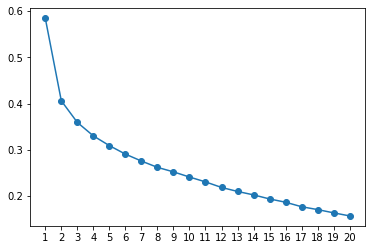

Accuracy :0.8943


In [ ]:
train_Lenet(learning_rate=0.001, scheduler_name='StepLR', scheduler_step_size=3200, scheduler_gamma=0.9)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.01
scheduler name : StepLR
scheduler step size : 100
scheduler gamma : 0.9
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.5138333322107791
epoch : 2 	training_loss : 0.3625050102174282
epoch : 3 	training_loss : 0.30642495313038415
epoch : 4 	training_loss : 0.26976980914672233
epoch : 5 	training_loss : 0.24482273253301756
epoch : 6 	training_loss : 0.23049245174974192
epoch : 7 	training_loss : 0.22226559723416975
epoch : 8 	training_loss : 0.21761161107569935
epoch : 9 	training_loss : 0.2148761066173514
epoch : 10 	training_loss : 0.21349653581778202
epoch : 11 	training_loss : 0.21270909768839652
epoch : 12 	training_loss : 0.21225793966402612
epoch : 13 	training_loss : 0.21203059827287996
epoch : 14 	training_loss : 0.211903863

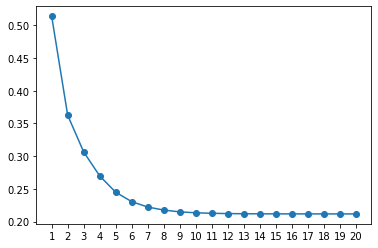

Accuracy :0.8906


In [ ]:
train_Lenet(learning_rate=0.01, scheduler_name='StepLR', scheduler_step_size=100, scheduler_gamma=0.9)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.01
scheduler name : StepLR
scheduler step size : 200
scheduler gamma : 0.9
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.5453331395238639
epoch : 2 	training_loss : 0.40354852688809234
epoch : 3 	training_loss : 0.35991684012115
epoch : 4 	training_loss : 0.3210926263406872
epoch : 5 	training_loss : 0.2935461398462459
epoch : 6 	training_loss : 0.2667821898808085
epoch : 7 	training_loss : 0.24409307700892308
epoch : 8 	training_loss : 0.22471638688196757
epoch : 9 	training_loss : 0.21071226153522746
epoch : 10 	training_loss : 0.20020563216259105
epoch : 11 	training_loss : 0.1918026228124895
epoch : 12 	training_loss : 0.18550014302134527
epoch : 13 	training_loss : 0.1808000300948819
epoch : 14 	training_loss : 0.177286661807447

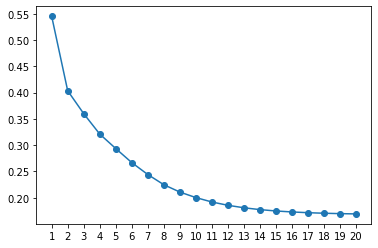

Accuracy :0.8881


In [ ]:
train_Lenet(learning_rate=0.01, scheduler_name='StepLR', scheduler_step_size=200, scheduler_gamma=0.9)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.01
scheduler name : StepLR
scheduler step size : 400
scheduler gamma : 0.9
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.5480396189788981
epoch : 2 	training_loss : 0.4112331627806025
epoch : 3 	training_loss : 0.38226723673443036
epoch : 4 	training_loss : 0.35377364059289335
epoch : 5 	training_loss : 0.3339955593893925
epoch : 6 	training_loss : 0.3162764209508894
epoch : 7 	training_loss : 0.2923758566503723
epoch : 8 	training_loss : 0.27601169555137595
epoch : 9 	training_loss : 0.259106130823493
epoch : 10 	training_loss : 0.24268633543203297
epoch : 11 	training_loss : 0.22710791987677412
epoch : 12 	training_loss : 0.21100976332401228
epoch : 13 	training_loss : 0.1949148685485126
epoch : 14 	training_loss : 0.18282242620363

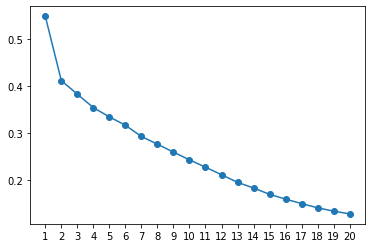

Accuracy :0.8852


In [ ]:
train_Lenet(learning_rate=0.01, scheduler_name='StepLR', scheduler_step_size=400, scheduler_gamma=0.9)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.01
scheduler name : StepLR
scheduler step size : 800
scheduler gamma : 0.9
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.5762661560376486
epoch : 2 	training_loss : 0.437494908620914
epoch : 3 	training_loss : 0.41599478011329993
epoch : 4 	training_loss : 0.39315080448985057
epoch : 5 	training_loss : 0.3786434741318223
epoch : 6 	training_loss : 0.36307969594995176
epoch : 7 	training_loss : 0.3461530820777022
epoch : 8 	training_loss : 0.34075666675964994
epoch : 9 	training_loss : 0.3234682255486645
epoch : 10 	training_loss : 0.30981657023231135
epoch : 11 	training_loss : 0.30257535770535443
epoch : 12 	training_loss : 0.2879115066553153
epoch : 13 	training_loss : 0.2762016362076008
epoch : 14 	training_loss : 0.26848781081537

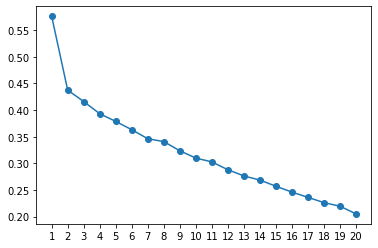

Accuracy :0.8862


In [ ]:
train_Lenet(learning_rate=0.01, scheduler_name='StepLR', scheduler_step_size=800, scheduler_gamma=0.9)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.01
scheduler name : StepLR
scheduler step size : 1600
scheduler gamma : 0.9
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.5362535458058113
epoch : 2 	training_loss : 0.43994408744076824
epoch : 3 	training_loss : 0.42678880838056443
epoch : 4 	training_loss : 0.4107832701255881
epoch : 5 	training_loss : 0.410338961854577
epoch : 6 	training_loss : 0.39820892398556085
epoch : 7 	training_loss : 0.384315097903212
epoch : 8 	training_loss : 0.37685591772198673
epoch : 9 	training_loss : 0.3729591053972643
epoch : 10 	training_loss : 0.36704116749266763
epoch : 11 	training_loss : 0.3705488968392211
epoch : 12 	training_loss : 0.35410534881055394
epoch : 13 	training_loss : 0.3569569425781568
epoch : 14 	training_loss : 0.34795008624593

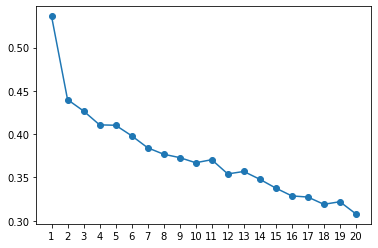

Accuracy :0.8711


In [ ]:
train_Lenet(learning_rate=0.01, scheduler_name='StepLR', scheduler_step_size=1600, scheduler_gamma=0.9)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.01
scheduler name : StepLR
scheduler step size : 3200
scheduler gamma : 0.9
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.5789371017615002
epoch : 2 	training_loss : 0.435064281870921
epoch : 3 	training_loss : 0.4264937089631953
epoch : 4 	training_loss : 0.4162152802447481
epoch : 5 	training_loss : 0.4147975791742406
epoch : 6 	training_loss : 0.4150200142959753
epoch : 7 	training_loss : 0.39544710499544933
epoch : 8 	training_loss : 0.3934672372788193
epoch : 9 	training_loss : 0.3983398539324603
epoch : 10 	training_loss : 0.39226419255137474
epoch : 11 	training_loss : 0.392473282366991
epoch : 12 	training_loss : 0.38582619709273197
epoch : 13 	training_loss : 0.376007248386741
epoch : 14 	training_loss : 0.3719922996312382
e

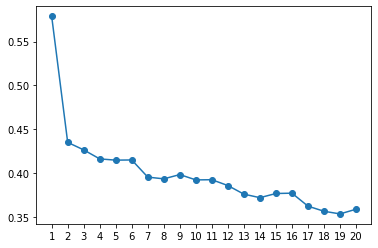

Accuracy :0.8522


In [ ]:
train_Lenet(learning_rate=0.01, scheduler_name='StepLR', scheduler_step_size=3200, scheduler_gamma=0.9)

# optimizer parameter - learning rate

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.6187575425207613
epoch : 2 	training_loss : 0.42165478328863815
epoch : 3 	training_loss : 0.36762364581227286
epoch : 4 	training_loss : 0.33834032990038376
epoch : 5 	training_loss : 0.31562651822964266
epoch : 6 	training_loss : 0.2969426575427255
epoch : 7 	training_loss : 0.28478869023422393
epoch : 8 	training_loss : 0.27078031772126715
epoch : 9 	training_loss : 0.2580676428725322
epoch : 10 	training_loss : 0.24724048213412353
epoch : 11 	training_loss : 0.237280331812799
epoch : 12 	training_loss : 0.22747938346117766
epoch : 13 	training_loss : 0.21970197127511115
epoch : 14 	training_loss : 0.2119521393

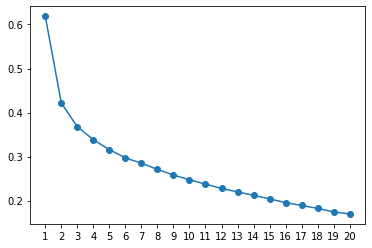

Accuracy :0.8946


In [ ]:
train_Lenet(learning_rate=0.001)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.0001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 1.032063073714574
epoch : 2 	training_loss : 0.6369053021570044
epoch : 3 	training_loss : 0.5668357674777502
epoch : 4 	training_loss : 0.527209066649278
epoch : 5 	training_loss : 0.5002740390102068
epoch : 6 	training_loss : 0.4787459927797322
epoch : 7 	training_loss : 0.45926826601227116
epoch : 8 	training_loss : 0.44468780030806815
epoch : 9 	training_loss : 0.4319568471858895
epoch : 10 	training_loss : 0.4209667780001963
epoch : 11 	training_loss : 0.4100122858087219
epoch : 12 	training_loss : 0.401229893043637
epoch : 13 	training_loss : 0.39285698021451626
epoch : 14 	training_loss : 0.38502286953230674

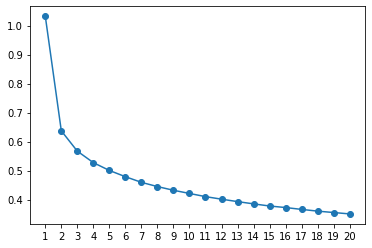

Accuracy :0.8624


In [ ]:
train_Lenet(learning_rate=0.0001)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.0002
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.8437147465844952
epoch : 2 	training_loss : 0.5503435026109216
epoch : 3 	training_loss : 0.490643637602528
epoch : 4 	training_loss : 0.4533689357837042
epoch : 5 	training_loss : 0.42729324343303826
epoch : 6 	training_loss : 0.4077813456952572
epoch : 7 	training_loss : 0.38995995027323577
epoch : 8 	training_loss : 0.3765505272895096
epoch : 9 	training_loss : 0.36433258824050424
epoch : 10 	training_loss : 0.3536464362343153
epoch : 11 	training_loss : 0.34702548551062806
epoch : 12 	training_loss : 0.33730529072384025
epoch : 13 	training_loss : 0.3287838586171467
epoch : 14 	training_loss : 0.3234266419708

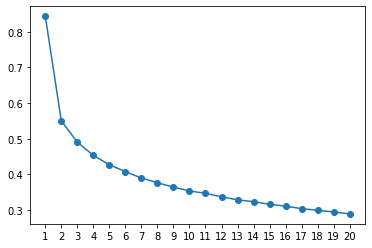

Accuracy :0.8757


In [ ]:
train_Lenet(learning_rate=0.0002)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.0004
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.7279877336323257
epoch : 2 	training_loss : 0.4982179388403897
epoch : 3 	training_loss : 0.43954919504622614
epoch : 4 	training_loss : 0.40307281548778245
epoch : 5 	training_loss : 0.3754351506382226
epoch : 6 	training_loss : 0.3548885261764129
epoch : 7 	training_loss : 0.3391618776321415
epoch : 8 	training_loss : 0.32490739926695805
epoch : 9 	training_loss : 0.31368492633104345
epoch : 10 	training_loss : 0.30428190703193353
epoch : 11 	training_loss : 0.29558991183837235
epoch : 12 	training_loss : 0.28713425949215915
epoch : 13 	training_loss : 0.2789660481363537
epoch : 14 	training_loss : 0.2725146018

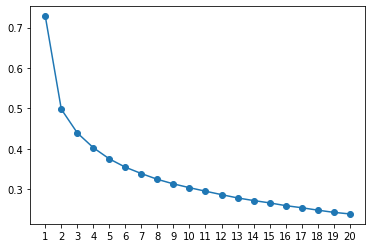

Accuracy :0.8903


In [ ]:
train_Lenet(learning_rate=0.0004)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.0008
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.6240380738675595
epoch : 2 	training_loss : 0.4312675282110773
epoch : 3 	training_loss : 0.3782778915514545
epoch : 4 	training_loss : 0.3476080599923932
epoch : 5 	training_loss : 0.3240703739970925
epoch : 6 	training_loss : 0.3086542385444044
epoch : 7 	training_loss : 0.2946450110773244
epoch : 8 	training_loss : 0.2814803546170393
epoch : 9 	training_loss : 0.2701596002156536
epoch : 10 	training_loss : 0.2595077771569295
epoch : 11 	training_loss : 0.25011661530782797
epoch : 12 	training_loss : 0.24144058949003624
epoch : 13 	training_loss : 0.23197399746626624
epoch : 14 	training_loss : 0.22461978259185

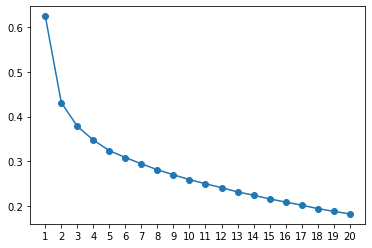

Accuracy :0.8939


In [ ]:
train_Lenet(learning_rate=0.0008)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.0016
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.5478810033202174
epoch : 2 	training_loss : 0.3905633410811422
epoch : 3 	training_loss : 0.34572349262734264
epoch : 4 	training_loss : 0.31956391602754614
epoch : 5 	training_loss : 0.29752632066607465
epoch : 6 	training_loss : 0.28208616218219185
epoch : 7 	training_loss : 0.26676336842278664
epoch : 8 	training_loss : 0.25337862440695363
epoch : 9 	training_loss : 0.23946059420704852
epoch : 10 	training_loss : 0.2271296135832864
epoch : 11 	training_loss : 0.2195812836786112
epoch : 12 	training_loss : 0.20770837976286802
epoch : 13 	training_loss : 0.1996976747736333
epoch : 14 	training_loss : 0.189285078

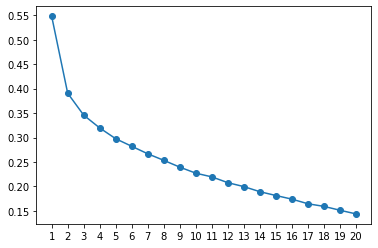

Accuracy :0.8931


In [ ]:
train_Lenet(learning_rate=0.0016)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.0032
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.51618105083704
epoch : 2 	training_loss : 0.3727728532503047
epoch : 3 	training_loss : 0.33347545241316157
epoch : 4 	training_loss : 0.31119157078365495
epoch : 5 	training_loss : 0.29523323970536414
epoch : 6 	training_loss : 0.28027311979482594
epoch : 7 	training_loss : 0.2694248032694065
epoch : 8 	training_loss : 0.2583369201049211
epoch : 9 	training_loss : 0.24935807020713893
epoch : 10 	training_loss : 0.23889163520187143
epoch : 11 	training_loss : 0.23097965019444633
epoch : 12 	training_loss : 0.22529489859938628
epoch : 13 	training_loss : 0.21622754838317618
epoch : 14 	training_loss : 0.2121395670

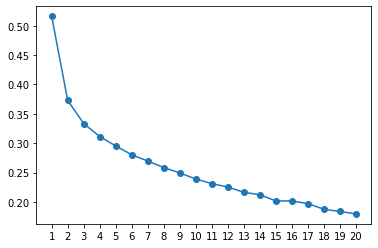

Accuracy :0.8874


In [ ]:
train_Lenet(learning_rate=0.0032)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.0064
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.51006838987271
epoch : 2 	training_loss : 0.3915613585462171
epoch : 3 	training_loss : 0.3682814854631821
epoch : 4 	training_loss : 0.35174130196372677
epoch : 5 	training_loss : 0.3401208450893565
epoch : 6 	training_loss : 0.33717375857134657
epoch : 7 	training_loss : 0.3313798687358699
epoch : 8 	training_loss : 0.3250195976595086
epoch : 9 	training_loss : 0.3160669191430014
epoch : 10 	training_loss : 0.3150151549528047
epoch : 11 	training_loss : 0.3179951080059009
epoch : 12 	training_loss : 0.31114630840718727
epoch : 13 	training_loss : 0.3096816489348811
epoch : 14 	training_loss : 0.3108047528813284

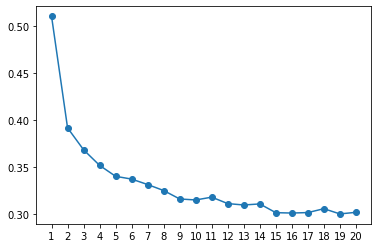

Accuracy :0.8741


In [ ]:
train_Lenet(learning_rate=0.0064)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.0128
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.6037508361041537
epoch : 2 	training_loss : 0.4783688039580979
epoch : 3 	training_loss : 0.4812037942806878
epoch : 4 	training_loss : 0.4839437962075072
epoch : 5 	training_loss : 0.4824469013015427
epoch : 6 	training_loss : 0.48858636289834956
epoch : 7 	training_loss : 0.4819534145792321
epoch : 8 	training_loss : 0.4988680599133176
epoch : 9 	training_loss : 0.49595303369065086
epoch : 10 	training_loss : 0.47638089433312397
epoch : 11 	training_loss : 0.4805862305810052
epoch : 12 	training_loss : 0.49009065931042073
epoch : 13 	training_loss : 0.4689386853079008
epoch : 14 	training_loss : 0.5060898659626

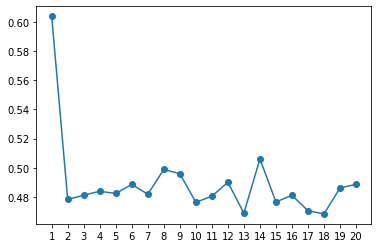

Accuracy :0.8136


In [ ]:
train_Lenet(learning_rate=0.0128)

# optimizer parameter - optimizer type

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.5937748376031718
epoch : 2 	training_loss : 0.4075403103480738
epoch : 3 	training_loss : 0.3624006781478723
epoch : 4 	training_loss : 0.33420978911220955
epoch : 5 	training_loss : 0.31375193335115936
epoch : 6 	training_loss : 0.29790582684179134
epoch : 7 	training_loss : 0.2810117998470863
epoch : 8 	training_loss : 0.26820459458977
epoch : 9 	training_loss : 0.2564443933342893
epoch : 10 	training_loss : 0.24587894907842087
epoch : 11 	training_loss : 0.23359458415458606
epoch : 12 	training_loss : 0.22519160710275185
epoch : 13 	training_loss : 0.2153947535778085
epoch : 14 	training_loss : 0.20581679037461

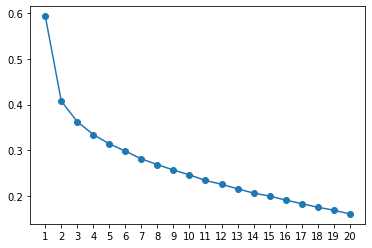

Accuracy :0.8967


In [ ]:
train_Lenet(optimizer_name='Adam')

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  SGD
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 2.2327298816045116
epoch : 2 	training_loss : 1.9449730346600214
epoch : 3 	training_loss : 1.4606297514836
epoch : 4 	training_loss : 1.1656673982739438
epoch : 5 	training_loss : 1.0310135473807647
epoch : 6 	training_loss : 0.950175972680251
epoch : 7 	training_loss : 0.892120480934778
epoch : 8 	training_loss : 0.846483267347018
epoch : 9 	training_loss : 0.8091684358318648
epoch : 10 	training_loss : 0.7782661387324326
epoch : 11 	training_loss : 0.7526199358701705
epoch : 12 	training_loss : 0.731503544251124
epoch : 13 	training_loss : 0.713746660699446
epoch : 14 	training_loss : 0.6985744018356003
epoch : 15

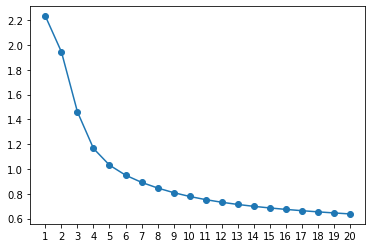

Accuracy :0.7593


In [ ]:
train_Lenet(optimizer_name='SGD')

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  RMSprop
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.5719735958675547
epoch : 2 	training_loss : 0.40593696157137527
epoch : 3 	training_loss : 0.3564660529295607
epoch : 4 	training_loss : 0.325313443802297
epoch : 5 	training_loss : 0.3045862254997095
epoch : 6 	training_loss : 0.2869374294703205
epoch : 7 	training_loss : 0.27211854252964246
epoch : 8 	training_loss : 0.25871063090860835
epoch : 9 	training_loss : 0.24672357937941994
epoch : 10 	training_loss : 0.23600257750600584
epoch : 11 	training_loss : 0.2253272504359481
epoch : 12 	training_loss : 0.2161798460036519
epoch : 13 	training_loss : 0.2061570717953146
epoch : 14 	training_loss : 0.19816244177

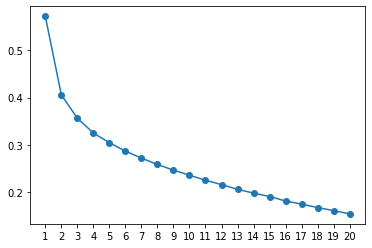

Accuracy :0.8923


In [ ]:
train_Lenet(optimizer_name='RMSprop')

# loss function

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.6065581858654817
epoch : 2 	training_loss : 0.41584018650154314
epoch : 3 	training_loss : 0.36662216340502063
epoch : 4 	training_loss : 0.33611698463559175
epoch : 5 	training_loss : 0.3132741793245079
epoch : 6 	training_loss : 0.2982433762152989
epoch : 7 	training_loss : 0.2817628322045007
epoch : 8 	training_loss : 0.2701565208286047
epoch : 9 	training_loss : 0.25979104931155816
epoch : 10 	training_loss : 0.24856663712610821
epoch : 11 	training_loss : 0.2383883121858041
epoch : 12 	training_loss : 0.22844507317990068
epoch : 13 	training_loss : 0.21938018186638752
epoch : 14 	training_loss : 0.21122658912

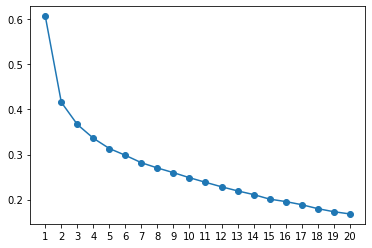

Accuracy :0.8971


In [ ]:
train_Lenet(loss_function_name='CrossEntropyLoss')

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : MSELoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.030483113691831654
epoch : 2 	training_loss : 0.021455154546226055
epoch : 3 	training_loss : 0.01896900478595247
epoch : 4 	training_loss : 0.01756045123329385
epoch : 5 	training_loss : 0.016512467847205684
epoch : 6 	training_loss : 0.015786007408363115
epoch : 7 	training_loss : 0.015072220380728427
epoch : 8 	training_loss : 0.014423504730220893
epoch : 9 	training_loss : 0.01393474506912753
epoch : 10 	training_loss : 0.013301850668309878
epoch : 11 	training_loss : 0.012795333752874293
epoch : 12 	training_loss : 0.012378946219493314
epoch : 13 	training_loss : 0.011935995226182671
epoch : 14 	training_loss : 0.0113

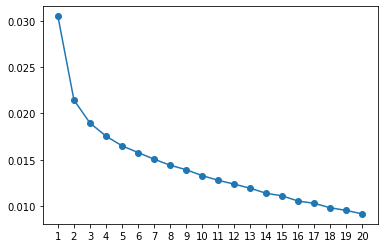

Accuracy :0.8898


In [ ]:
train_Lenet(loss_function_name='MSELoss')

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : MultiMarginLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.10083147623265772
epoch : 2 	training_loss : 0.059537299346799674
epoch : 3 	training_loss : 0.05094642448704692
epoch : 4 	training_loss : 0.04586576329078521
epoch : 5 	training_loss : 0.042018924987254035
epoch : 6 	training_loss : 0.03880912058055404
epoch : 7 	training_loss : 0.03657477573336408
epoch : 8 	training_loss : 0.03424897536014517
epoch : 9 	training_loss : 0.03244297993990277
epoch : 10 	training_loss : 0.030675030816346437
epoch : 11 	training_loss : 0.02914304786206536
epoch : 12 	training_loss : 0.02776318799083434
epoch : 13 	training_loss : 0.026605369338455285
epoch : 14 	training_loss : 0.02

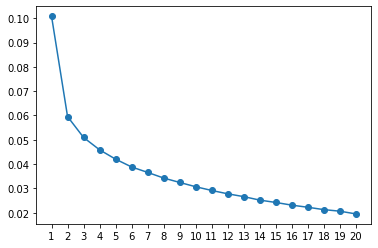

Accuracy :0.8962


In [ ]:
train_Lenet(loss_function_name='MultiMarginLoss')

# batch size

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.5887707717716689
epoch : 2 	training_loss : 0.41581317981084204
epoch : 3 	training_loss : 0.36761257102092154
epoch : 4 	training_loss : 0.3375736082469426
epoch : 5 	training_loss : 0.31514649589856436
epoch : 6 	training_loss : 0.29707527295996716
epoch : 7 	training_loss : 0.28192556003729463
epoch : 8 	training_loss : 0.2701023300364614
epoch : 9 	training_loss : 0.2583729865774511
epoch : 10 	training_loss : 0.24708334945142257
epoch : 11 	training_loss : 0.23747673300405384
epoch : 12 	training_loss : 0.22801096999396891
epoch : 13 	training_loss : 0.21840794449051243
epoch : 14 	training_loss : 0.209848911

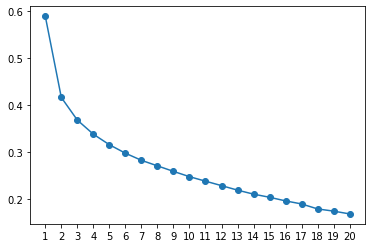

Accuracy :0.894


In [ ]:
train_Lenet(batch_size=100)

using device : cuda
training epoch : 20
batch size : 10
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.4900478864468175
epoch : 2 	training_loss : 0.36364205410998784
epoch : 3 	training_loss : 0.32711836575219905
epoch : 4 	training_loss : 0.3038830161086911
epoch : 5 	training_loss : 0.28476087959762664
epoch : 6 	training_loss : 0.2698295929978687
epoch : 7 	training_loss : 0.25617938368389226
epoch : 8 	training_loss : 0.2459706584038788
epoch : 9 	training_loss : 0.2374365976064009
epoch : 10 	training_loss : 0.22638338529454405
epoch : 11 	training_loss : 0.21741124068177295
epoch : 12 	training_loss : 0.20880081386576607
epoch : 13 	training_loss : 0.19879989988141206
epoch : 14 	training_loss : 0.19151388882

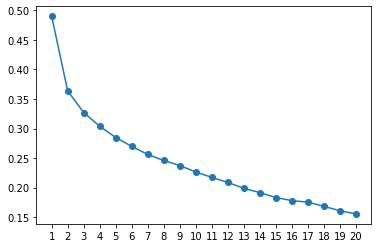

Accuracy :0.8819


In [ ]:
train_Lenet(batch_size=10)

using device : cuda
training epoch : 20
batch size : 20
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.502605277194332
epoch : 2 	training_loss : 0.3654025568533694
epoch : 3 	training_loss : 0.3223018933019294
epoch : 4 	training_loss : 0.2982845311177273
epoch : 5 	training_loss : 0.27576566798954
epoch : 6 	training_loss : 0.26056827254655385
epoch : 7 	training_loss : 0.24485771462445427
epoch : 8 	training_loss : 0.23269280381485233
epoch : 9 	training_loss : 0.21934733038147275
epoch : 10 	training_loss : 0.21148178397227665
epoch : 11 	training_loss : 0.200166594400536
epoch : 12 	training_loss : 0.1911335817448951
epoch : 13 	training_loss : 0.18078299664302414
epoch : 14 	training_loss : 0.17252839203504836

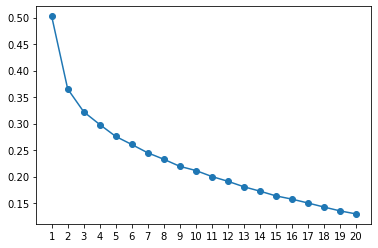

Accuracy :0.8894


In [ ]:
train_Lenet(batch_size=20)

using device : cuda
training epoch : 20
batch size : 40
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.5243840074688206
epoch : 2 	training_loss : 0.375480889260769
epoch : 3 	training_loss : 0.33357662116984527
epoch : 4 	training_loss : 0.3054156487161915
epoch : 5 	training_loss : 0.2841361474494136
epoch : 6 	training_loss : 0.2641371151308219
epoch : 7 	training_loss : 0.25065300916135325
epoch : 8 	training_loss : 0.23663412949194565
epoch : 9 	training_loss : 0.22365380959833683
epoch : 10 	training_loss : 0.21257398335884023
epoch : 11 	training_loss : 0.19985433948412581
epoch : 12 	training_loss : 0.19105938033014527
epoch : 13 	training_loss : 0.18260704667617852
epoch : 14 	training_loss : 0.172187176795

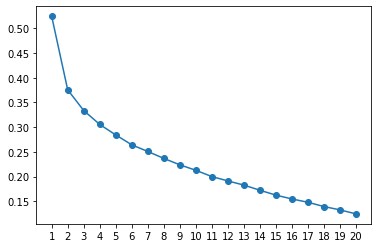

Accuracy :0.8897


In [ ]:
train_Lenet(batch_size=40)

using device : cuda
training epoch : 20
batch size : 80
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.562104420363903
epoch : 2 	training_loss : 0.39429932395617145
epoch : 3 	training_loss : 0.3527688120206197
epoch : 4 	training_loss : 0.32453971490263966
epoch : 5 	training_loss : 0.30281769379973406
epoch : 6 	training_loss : 0.28399891965587953
epoch : 7 	training_loss : 0.2711497734884423
epoch : 8 	training_loss : 0.25772222065925604
epoch : 9 	training_loss : 0.2451436433692775
epoch : 10 	training_loss : 0.23242941287159924
epoch : 11 	training_loss : 0.2239504806300006
epoch : 12 	training_loss : 0.21354027469456185
epoch : 13 	training_loss : 0.20547138496736705
epoch : 14 	training_loss : 0.197067222719

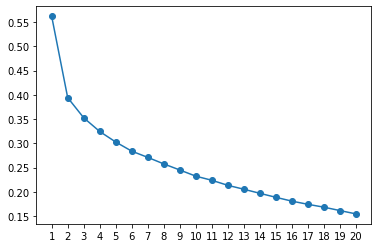

Accuracy :0.8948


In [ ]:
train_Lenet(batch_size=80)

using device : cuda
training epoch : 20
batch size : 160
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.6476017827192942
epoch : 2 	training_loss : 0.43956394004821786
epoch : 3 	training_loss : 0.3849507731199266
epoch : 4 	training_loss : 0.3530229199727376
epoch : 5 	training_loss : 0.32842888263861353
epoch : 6 	training_loss : 0.3088593384027482
epoch : 7 	training_loss : 0.2965883056720097
epoch : 8 	training_loss : 0.28474243024985013
epoch : 9 	training_loss : 0.2735912323792774
epoch : 10 	training_loss : 0.26368495782216383
epoch : 11 	training_loss : 0.25368911663691207
epoch : 12 	training_loss : 0.24562547882397961
epoch : 13 	training_loss : 0.23932462888956063
epoch : 14 	training_loss : 0.23073950258

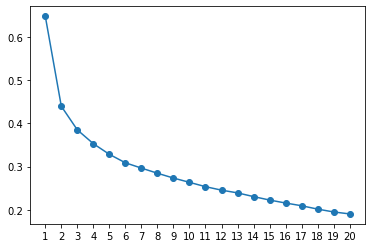

Accuracy :0.8956


In [ ]:
train_Lenet(batch_size=160)

using device : cuda
training epoch : 20
batch size : 320
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.7840733944094758
epoch : 2 	training_loss : 0.5106830529988136
epoch : 3 	training_loss : 0.4402470861207993
epoch : 4 	training_loss : 0.4019939864383027
epoch : 5 	training_loss : 0.3736253242122935
epoch : 6 	training_loss : 0.35549239240546926
epoch : 7 	training_loss : 0.340960682554041
epoch : 8 	training_loss : 0.32775931259527546
epoch : 9 	training_loss : 0.31412057929179255
epoch : 10 	training_loss : 0.30727584014601894
epoch : 11 	training_loss : 0.29810036591348815
epoch : 12 	training_loss : 0.2883669229592866
epoch : 13 	training_loss : 0.2804493785382593
epoch : 14 	training_loss : 0.27089761747395

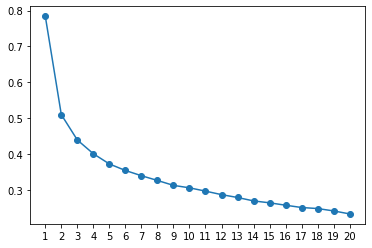

Accuracy :0.8877


In [ ]:
train_Lenet(batch_size=320)

using device : cuda
training epoch : 20
batch size : 640
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.9140648059947515
epoch : 2 	training_loss : 0.5487910730223501
epoch : 3 	training_loss : 0.4825555627704948
epoch : 4 	training_loss : 0.4413999376758451
epoch : 5 	training_loss : 0.4097939585485766
epoch : 6 	training_loss : 0.3917608126517264
epoch : 7 	training_loss : 0.37249942428322236
epoch : 8 	training_loss : 0.3596828922789583
epoch : 9 	training_loss : 0.3459203121482686
epoch : 10 	training_loss : 0.33592101675207897
epoch : 11 	training_loss : 0.32751354671293686
epoch : 12 	training_loss : 0.3182812624721118
epoch : 13 	training_loss : 0.3119272435865095
epoch : 14 	training_loss : 0.307176671681865

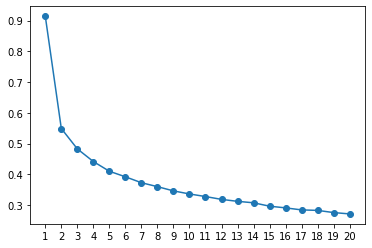

Accuracy :0.8824


In [ ]:
train_Lenet(batch_size=640)

using device : cuda
training epoch : 20
batch size : 1280
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 1.06914623664773
epoch : 2 	training_loss : 0.6275417234586632
epoch : 3 	training_loss : 0.5457656409429466
epoch : 4 	training_loss : 0.49703644475211267
epoch : 5 	training_loss : 0.4638795444498891
epoch : 6 	training_loss : 0.43823557962541987
epoch : 7 	training_loss : 0.4198289610769438
epoch : 8 	training_loss : 0.4040280029825542
epoch : 9 	training_loss : 0.38603574426277815
epoch : 10 	training_loss : 0.3785465897425362
epoch : 11 	training_loss : 0.3697747367879619
epoch : 12 	training_loss : 0.36109061927899067
epoch : 13 	training_loss : 0.35442300270433014
epoch : 14 	training_loss : 0.34497399045073

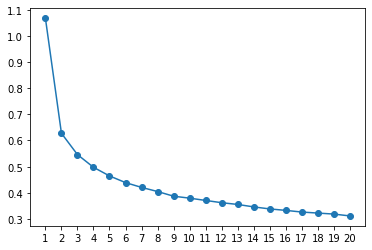

Accuracy :0.8729


In [ ]:
train_Lenet(batch_size=1280)

# be creative and analytical

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.6022232558081547
epoch : 2 	training_loss : 0.4093605014433464
epoch : 3 	training_loss : 0.36291954206923677
epoch : 4 	training_loss : 0.33346481939156847
epoch : 5 	training_loss : 0.3136953362077473
epoch : 6 	training_loss : 0.2945469028254348
epoch : 7 	training_loss : 0.28085130119075397
epoch : 8 	training_loss : 0.2665092867488663
epoch : 9 	training_loss : 0.2578994916503625
epoch : 10 	training_loss : 0.2464731881270805
epoch : 11 	training_loss : 0.2367818635329602
epoch : 12 	training_loss : 0.22663164985676598
epoch : 13 	training_loss : 0.21787621052314848
epoch : 14 	training_loss : 0.2103903758153

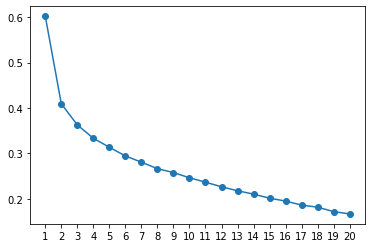

Accuracy :0.898


In [ ]:
train_Lenet(activation_function='tanh')

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : relu
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.6376726399362093
epoch : 2 	training_loss : 0.43507320451239767
epoch : 3 	training_loss : 0.3847986630847059
epoch : 4 	training_loss : 0.353741263796886
epoch : 5 	training_loss : 0.33006159608562785
epoch : 6 	training_loss : 0.31355175179739825
epoch : 7 	training_loss : 0.29708753209561134
epoch : 8 	training_loss : 0.2839416490991908
epoch : 9 	training_loss : 0.27029314730316406
epoch : 10 	training_loss : 0.25994927664597844
epoch : 11 	training_loss : 0.2518402079865337
epoch : 12 	training_loss : 0.24234253451228122
epoch : 13 	training_loss : 0.2334366928289336
epoch : 14 	training_loss : 0.223077678891

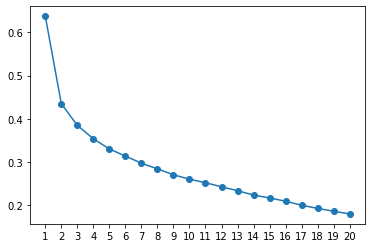

Accuracy :0.9019


In [ ]:
train_Lenet(activation_function='relu')

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : leaky_relu
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.6696104001998897
epoch : 2 	training_loss : 0.437105017080903
epoch : 3 	training_loss : 0.38510479847590146
epoch : 4 	training_loss : 0.35020899434884395
epoch : 5 	training_loss : 0.3237428560107945
epoch : 6 	training_loss : 0.30635937766482413
epoch : 7 	training_loss : 0.2895328145225844
epoch : 8 	training_loss : 0.27364528931677323
epoch : 9 	training_loss : 0.2606726797918479
epoch : 10 	training_loss : 0.25058821669469244
epoch : 11 	training_loss : 0.23747536748647688
epoch : 12 	training_loss : 0.23002479876702053
epoch : 13 	training_loss : 0.22113121223325552
epoch : 14 	training_loss : 0.21173

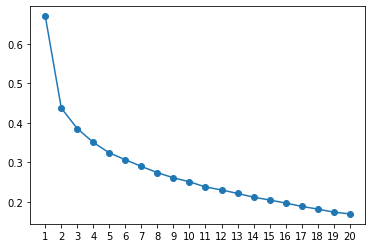

Accuracy :0.905


In [ ]:
train_Lenet(activation_function='leaky_relu')

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : max
using dropout layer : False
epoch : 1 	training_loss : 0.5357868914554518
epoch : 2 	training_loss : 0.3555131006240846
epoch : 3 	training_loss : 0.3112439738710724
epoch : 4 	training_loss : 0.2854270962377388
epoch : 5 	training_loss : 0.26808662475397177
epoch : 6 	training_loss : 0.24919479943811895
epoch : 7 	training_loss : 0.23629495027164613
epoch : 8 	training_loss : 0.22148661758750643
epoch : 9 	training_loss : 0.209891822350522
epoch : 10 	training_loss : 0.19663269968082528
epoch : 11 	training_loss : 0.18572458080947385
epoch : 12 	training_loss : 0.17699998490512403
epoch : 13 	training_loss : 0.16651643594106053
epoch : 14 	training_loss : 0.15780396280

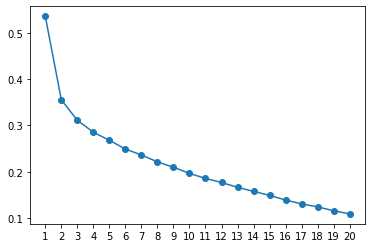

Accuracy :0.9082


In [ ]:
train_Lenet(pooling_layer='max')

using device : cuda



Extracting Fashion_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to Fashion_data/FashionMNIST/raw




Extracting Fashion_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to Fashion_data/FashionMNIST/raw




Extracting Fashion_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to Fashion_data/FashionMNIST/raw




Extracting Fashion_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to Fashion_data/FashionMNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : True
pooling layer : avg
using dropout layer : False
epoch : 1 	training_loss : 0.4564687193433446
epoch : 2 	training_loss : 0.32112725518643875
epoch : 3 	training_loss : 0.27944299126664784
epoch : 4 	training_loss : 0.25552185858289417
epoch : 5 	training_loss : 0.23711511690169582
epoch : 6 	training_loss : 0.22263154086967304
epoch : 7 	training_loss : 0.20710227334251005
epoch : 8 	training_loss : 0.1964741619179648
epoch : 9 	training_loss : 0.18630864993979532
epoch : 10 	training_loss : 0.17444797749320665
epoch : 11 	training_loss : 0.1626270118542015
epoch : 12 	training_loss : 0.1553949390786388
epoch : 13 	training_loss : 0.147164378563563
epoch : 14 	training_loss : 0.13553843121354778
epoch : 

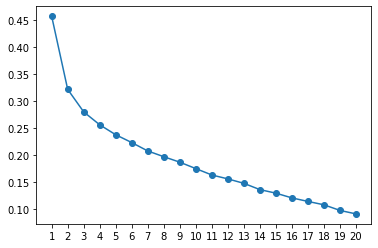

Accuracy :0.9088


In [ ]:
train_Lenet(use_batchnorm=True)

using device : cuda
training epoch : 20
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : tanh
convolutional channels : 6 16 120
using batch normalization? : False
pooling layer : avg
using dropout layer : True
epoch : 1 	training_loss : 0.6464348943034819
epoch : 2 	training_loss : 0.44898925987382704
epoch : 3 	training_loss : 0.39537846418718525
epoch : 4 	training_loss : 0.36487800747156146
epoch : 5 	training_loss : 0.3447611017773549
epoch : 6 	training_loss : 0.3296039090802273
epoch : 7 	training_loss : 0.3141102272147935
epoch : 8 	training_loss : 0.30269648113598435
epoch : 9 	training_loss : 0.2906275656570989
epoch : 10 	training_loss : 0.2813079141825433
epoch : 11 	training_loss : 0.27341642474134775
epoch : 12 	training_loss : 0.26201685659587376
epoch : 13 	training_loss : 0.25292652030785867
epoch : 14 	training_loss : 0.246651226592

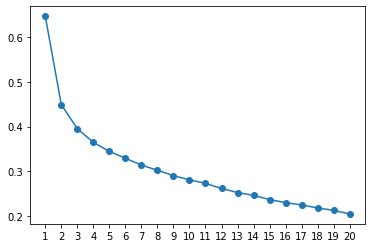

Accuracy :0.8976


In [ ]:
train_Lenet(use_dropout=True)

using device : cuda
training epoch : 50
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : relu
convolutional channels : 32 64 256
using batch normalization? : True
pooling layer : max
using dropout layer : False
epoch : 1 	training_loss : 0.35318597927689543
epoch : 2 	training_loss : 0.23506940063089135
epoch : 3 	training_loss : 0.19294838080803559
epoch : 4 	training_loss : 0.16235733697811772
epoch : 5 	training_loss : 0.13629490676335984
epoch : 6 	training_loss : 0.11563470141341294
epoch : 7 	training_loss : 0.09644649757693219
epoch : 8 	training_loss : 0.08211014976104089
epoch : 9 	training_loss : 0.06960701026953754
epoch : 10 	training_loss : 0.05967116194389144
epoch : 11 	training_loss : 0.046959004074645545
epoch : 12 	training_loss : 0.04577083123032934
epoch : 13 	training_loss : 0.03950851409696043
epoch : 14 	training_loss : 0.0365

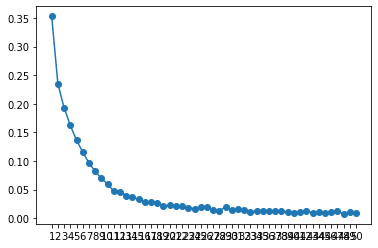

Accuracy :0.9206


In [ ]:
train_Lenet(training_epoch=50,loss_function_name='CrossEntropyLoss',
                activation_function='relu',
                first_channel=32,
                second_channel=64,
                third_channel=256,
                use_batchnorm=True,
                pooling_layer='max')

using device : cuda
training epoch : 50
batch size : 100
learning rate : 0.001
scheduler name : None
scheduler step size : None
scheduler gamma : None
optimizer name:  Adam
loss function : CrossEntropyLoss
activation function : leaky_relu
convolutional channels : 32 64 256
using batch normalization? : True
pooling layer : max
using dropout layer : False
epoch : 1 	training_loss : 0.34785058935483265
epoch : 2 	training_loss : 0.23601670835788047
epoch : 3 	training_loss : 0.19580159236987443
epoch : 4 	training_loss : 0.16122516202429935
epoch : 5 	training_loss : 0.13939158701648321
epoch : 6 	training_loss : 0.11434533086915812
epoch : 7 	training_loss : 0.09863347286358473
epoch : 8 	training_loss : 0.08249691240179038
epoch : 9 	training_loss : 0.07418327742566666
epoch : 10 	training_loss : 0.05996032153799512
epoch : 11 	training_loss : 0.05091480017600887
epoch : 12 	training_loss : 0.04838483478679941
epoch : 13 	training_loss : 0.039919347448546125
epoch : 14 	training_loss : 

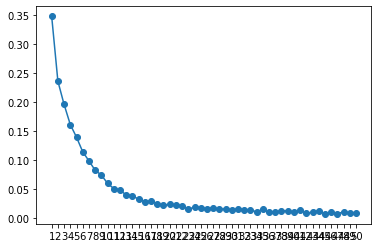

Accuracy :0.9207


In [ ]:
train_Lenet(training_epoch=50,
            optimizer_name='Adam',
            loss_function_name='CrossEntropyLoss',
            activation_function='leaky_relu',
            first_channel=32,
            second_channel=64,
            third_channel=256,
            use_batchnorm=True,
            pooling_layer='max')